<a href="https://colab.research.google.com/github/Tharunkumar176/image-caption-generator/blob/main/image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add # Import add directly from keras.layers

In [ ]:
!dir

sample_data


In [ ]:
def readTextFile(path):
    with open(path) as f:
        caption = f.read()
    return caption

In [ ]:
captions = readTextFile('/captions.txt')
captions = captions.split('\n')[:-1]
captions[161]

'1042020065_fb3d3ba5ba.jpg,A boy in a green shirt is looking down at many inflatable boats .'

In [ ]:
desc = {}

for x in captions:
    zyzz = x.split(',')
    img_name,img_captions= zyzz[0],zyzz[1]

    if desc.get(img_name) is None:
        desc[img_name] = []
    desc[img_name].append(img_captions)
desc['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

TypeError: Image data of dtype object cannot be converted to float

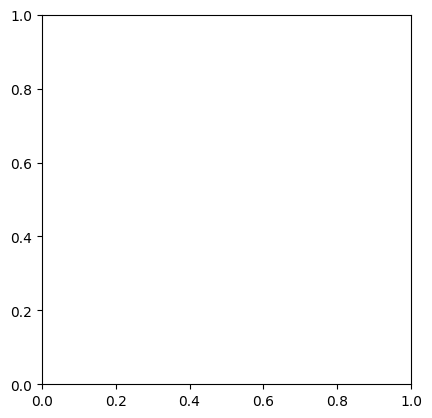

In [ ]:
import cv2
path = './dataset/images/1042020065_fb3d3ba5ba.jpg'
plt.imshow(cv2.imread(path))
plt.show()
desc['1042020065_fb3d3ba5ba.jpg']

In [ ]:
import cv2
import matplotlib.pyplot as plt

path = './dataset/images/1042020065_fb3d3ba5ba.jpg'

# Read the image using cv2.imread
img = cv2.imread(path)

# Check if the image was loaded successfully
if img is not None:
    # If loaded, display the image
    plt.imshow(img)
    plt.show()
    print(desc['1042020065_fb3d3ba5ba.jpg'])
else:
    # If loading failed, print an error message and check the file path
    print(f"Error: Could not load image from path: {path}")
    print("Please verify that the file path is correct and the image exists.")

Error: Could not load image from path: ./dataset/images/1042020065_fb3d3ba5ba.jpg
Please verify that the file path is correct and the image exists.


In [ ]:
import re
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s) > 1]
    sentence = ' '.join(sentence)
    return sentence

In [ ]:
for key, caption_list in desc.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
desc['1042020065_fb3d3ba5ba.jpg']

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [ ]:
with open('./dataset/description.txt','w') as f:
    f.write(str(desc))

In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('./dataset/'):
    os.makedirs('./dataset/')

with open('./dataset/description.txt','w') as f:
    f.write(str(desc))

In [ ]:
import json
descriptions = None
with open('./dataset/description.txt') as f:
    descriptions = f.read()
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [ ]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size(unique words In Vocab) : %d"% len(vocab))

Vocab Size(unique words In Vocab) : 8258


In [ ]:
vocab = set()
vocab.update(["hello", "apple"])
vocab.update(["hello"])
vocab.update(["hi"])
print(vocab)

{'apple', 'hello', 'hi'}


In [ ]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

In [ ]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words %d"%len(total_words))

Total Words 357792


In [ ]:
len(total_words), type(total_words)

(357792, list)

In [ ]:
import collections
counter = collections.Counter(total_words)
frq_cnt = dict(counter)
print(len(frq_cnt.keys()))
# print(frq_cnt)

8258


In [ ]:
sorted_freq_cnt = sorted(frq_cnt.items(), reverse = True, key=lambda x:x[1])

# filter
threshold =  10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words)) # 1800 unique words filter, this is going to be new vocab size

1800


In [ ]:
descriptions.get('1042020065_fb3d3ba5ba.jpg')

['boy in green shirt is looking down at many inflatable boats',
 'boy in green shirt watches kayakers',
 'boy looks over railing at the many boats and rafts below in the water',
 'young boy overlooking crowd of inflatable boats',
 'young boy wearing jersey looks down over ledge at many boats in the water']

Training and testing data


In [ ]:
len(descriptions.keys()), len(descriptions.values())

(8092, 8092)

In [ ]:
train_file_data = readTextFile('./dataset/train.txt')
test_file_data = readTextFile('./dataset/test.txt')

FileNotFoundError: [Errno 2] No such file or directory: './dataset/train.txt'

In [ ]:
import os

# Check if the train.txt file exists
train_file_path = './dataset/train.txt'
if not os.path.exists(train_file_path):
    print(f"Error: File not found at {train_file_path}")
    print("Please ensure that 'train.txt' is located in the './dataset/' directory.")
else:
    # If the file exists, proceed to read it
    train_file_data = readTextFile(train_file_path)
    test_file_data = readTextFile('./dataset/test.txt') # Assuming test.txt is also in the same location
    print("Files loaded successfully.")

Error: File not found at ./dataset/train.txt
Please ensure that 'train.txt' is located in the './dataset/' directory.
